#### Note: Does <u>not</u> work....

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import warnings

class Bloch_Simulator:
    def __init__(self, gamma=2.675 * 1e8,         # rad/(T*s) 
                       T1=1000 * 1e-3, T2=1000 * 1e-3,   # s 
                       M0=1.0, 
                       phi=0.0, 
                       omega_1=0.25 * 1e4,           # 1/s 
                       delta_omega=0.0,              # 1/s 
                       nz=1.0,                       # nmb. 
                       tw=1 * 1e-3,                  # s 
                       G=None, 
                       lower_bound=-np.inf, upper_bound=np.inf
                    ) -> None:
        # Constants
        self.delta_x = 2 * 1e-3  # m
        # Parameters
        self.gamma = gamma
        self.T1 = T1
        self.T2 = T2
        self.M0 = M0
        self.phi = phi
        self.omega_1 = omega_1
        self.delta_omega = delta_omega
        self.nz = nz
        self.tw = tw
        if G is None:
            self.G = 2*np.pi/(self.gamma*self.tw*self.delta_x)
        else:
            self.G = G
        # Pulse bounds
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        # Logged information
        self.last_solution = None
    

    def copy(self) : 
        return Bloch_Simulator(self.gamma, self.T1, self.T2, self.M0, self.phi, self.omega_1, 
                               self.delta_omega, self.nz, self.tw, self.G, self.lower_bound, self.upper_bound)
    
    def _safe_sinc(self, x):
        # x can be an array
        return np.where(np.isclose(x, 0.0), 1.0, np.sin(x)/x)

    def _get_Beff(self, t: float, x: np.ndarray, apply_sinc: bool) -> np.ndarray:
        B1 = self._get_omega1(t) / self.gamma
        Beff = np.zeros((x.size, 3))
        Beff[:, 0] = B1 * np.cos(self.phi)
        Beff[:, 1] = B1 * np.sin(self.phi)
        Beff[:, 2] = self.delta_omega / self.gamma

        if apply_sinc:
            arg = 2 * np.pi * t / self.tw
            Beff *= self._safe_sinc(arg)
        
        Beff[:, 2] += self.G * x

        return Beff

    def _get_omega1(self, t: float) -> float: 
        if self.lower_bound <= t <= self.upper_bound:
            return self.omega_1
        else:
            return 0

    def _diff_eqn(self, t: float, M_flat: np.ndarray, x: np.ndarray, apply_sinc: bool) -> np.ndarray:
        # Check if M_flat is 1D (non-vectorized) or 2D (vectorized)
        if M_flat.ndim == 1:
            # Non-vectorized: reshape into (N, 3) where N = number of spatial positions.
            M = M_flat.reshape(-1, 3)  # shape (N, 3)
            Beff = self._get_Beff(t, x, apply_sinc)  # shape (N, 3)

            # Precession: elementwise cross product over rows
            dMdt = - self.gamma * np.cross(M, Beff)
            # Relaxation terms
            dMdt[:, 0] += -M[:, 0] / self.T2
            dMdt[:, 1] += -M[:, 1] / self.T2
            dMdt[:, 2] += -(M[:, 2] - self.M0) / self.T1
            return dMdt.flatten()
        else:
            # Vectorized mode: M_flat shape is (N*3, m) where m is the number of simultaneous evaluations.
            m = M_flat.shape[1]  # number of simultaneous evaluations
            N = M_flat.size // (3 * m)  # number of spatial positions
            M = M_flat.reshape(N, 3, m)  # shape (N, 3, m)
            Beff = self._get_Beff(t, x, apply_sinc)  # shape (N, 3)
            # Expand Beff to (N, 3, m) so that it can be used in np.cross:
            Beff = Beff[:, :, np.newaxis]  # shape becomes (N, 3, 1) and broadcasts to (N, 3, m)

            # Compute the precession term with cross product along axis 1:
            dMdt = -self.gamma * np.cross(M, Beff, axis=1)  # result shape (N, 3, m)
            # Relaxation terms
            dMdt[:, 0, :] += -M[:, 0, :] / self.T2
            dMdt[:, 1, :] += -M[:, 1, :] / self.T2
            dMdt[:, 2, :] += -(M[:, 2, :] - self.M0) / self.T1
            return dMdt.reshape(N * 3, m)

    def solve_ivp(self, dt: float, tlin: np.ndarray, x: np.ndarray, apply_sinc=True, force_max_step_size=False, *args, **kwargs):
        # Initialize the M0 vector for all positions in x
        M0_init = np.zeros((x.size, 3))
        M0_init[:, 2] = self.M0
        M0_flat = M0_init.flatten()  

        solve_kwargs = {
            "fun": self._diff_eqn,
            "y0": M0_flat,
            "t_span": (tlin[0], tlin[-1]),
            "t_eval": tlin,
            "args": (x, apply_sinc,) + args,
            "rtol": 1e-6,
            "atol": 1e-9,
            "vectorized": True
        }
        solve_kwargs.update(kwargs)

        if force_max_step_size:
            solve_kwargs["max_step"] = dt

        solution = solve_ivp(**solve_kwargs)
                    
        if not solution.success : warnings.warn(solution.message, UserWarning)

        return solution
    
    def format_solution(self, solution, xs, time_where=None):
        # Reshape to (xs, 3, ts)
        Ms = solution.y.reshape(len(xs), 3, -1)
        
        if time_where is not None:
            # Find the index corresponding to the given time.
            index = np.where(np.isclose(solution.t, time_where))[0]
            print(index)
            
            Mxs = Ms[:, 0, index]
            Mys = Ms[:, 1, index]
            Mzs = Ms[:, 2, index]
            Mps = np.sqrt(Mxs**2 + Mys**2)
        else:
            Mxs = Ms[:, 0, :]
            Mys = Ms[:, 1, :]
            Mzs = Ms[:, 2, :]
            Mps = np.sqrt(Mxs**2 + Mys**2)

        return (Mxs, Mys, Mzs, Mps)


In [73]:
from tqdm import tqdm

In [74]:
def find_best_omega(solver, initial_bounds, bounds_step, tlin, dt, tolerance=1e-3) : 
    # Search space
    omegas_test = np.linspace(initial_bounds[0], initial_bounds[1], bounds_step)
    # Variables
    best_omega, best_res = None, None

    copy = solver.copy()

    for omega in tqdm(omegas_test) : 
        copy.omega_1 = omega
        #print(f"Testing omega: {omega}, solver.omega_1: {solver.omega_1}")
        # Run simulation
        solution = copy.solve_ivp(dt=dt, tlin=tlin, x=np.array(0), apply_sinc=True, force_max_step_size=False)
        last_value = solution.y[2][-1]
        #print(f"omega: {omega}, last_value: {last_value}")

        # Save best result
        if(best_omega is None) : 
            best_omega = omega
            best_res = last_value
        else : 
            diff = np.abs(best_res) - np.abs(last_value)
            if(diff > 0) : 
                best_omega = omega
                best_res = last_value

    # Warn if tolerance not achieved.
    if(best_res > tolerance) : warnings.warn("Did not reach tolerance.", UserWarning)

    return (best_omega, best_res)


In [75]:
import matplotlib.pyplot as plt

In [81]:
tw = 2*1e-3 # s
nz = 1.0
trf = nz * tw

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.01e-2)

lower_bound = -0.5 * trf
upper_bound = 0.5 * trf

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)

solver = Bloch_Simulator(tw=tw, lower_bound=lower_bound, upper_bound=upper_bound)

best_omega, best_res = find_best_omega(solver, initial_bounds=[0.1e4, 0.7e4], bounds_step=1000, tlin=tlin, dt=dt)

print(best_omega, best_res)

100%|██████████| 1000/1000 [02:33<00:00,  6.49it/s]

6663.663663663663 -0.0007314590450063048


In [82]:

solver = Bloch_Simulator(omega_1=best_omega, tw=tw, lower_bound=lower_bound, upper_bound=upper_bound)

Ms = []

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)

test = [0.001]

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=np.array(Ls), apply_sinc=True, force_max_step_size=False)

Mxs, Mys, Mzs, Mps = solver.format_solution(solution, Ls, time_where=0.5*trf)


[30000]


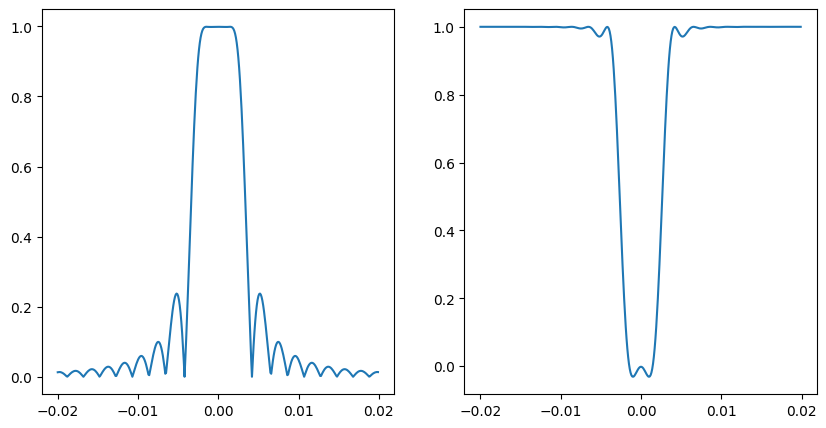

In [83]:

fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

#ax[0].plot(solution.t, Mxs[0])
#ax[0].plot(solution.t, Mys[0])
#ax[1].plot(solution.t, Mzs[0])

ax[0].plot(Ls, Mps)
ax[1].plot(Ls, Mzs)

In [31]:
print(Ms[:,2][0])

[1.         1.         1.         ... 0.99965528 0.99965528 0.99965528]


In [130]:

M0_init = np.zeros((10, 3))
print(M0_init)
M0_init[:,2] = 1
print(M0_init)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
